## Imports, constants and configuration

In [1]:
from requests import get
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

mdates.set_epoch("2021-01-01T00:00")

In [2]:
VACCINATION_UPTAKE = 0.95
FORECAST = 30
DATA_CUTOFF = "2021-01-01"
VCH_ADULT_POP = 994826

## Refresh data

The end goal is to estimate when a person of a given age would get their first vaccination. 
To achieve this, ideally we would want a time-series dataset of what percentage of the population has received a single dose, coupled with population and demographic statistics, as locally as possible.
This dataset, as far as I can tell, does not exist, so we must create what we can and approximate the rest.
BC's COVID-19 dashboard supplies the number of single-shot people at the Health Region level, which is the most local information available.
However, it does not supply time-series data for this, just the cumulative total and delta against the last report.
BC's official APIs seem to be almost completely unaware of vaccination data, but luckily a project run by students and faculty at the University of Saskatoon has been tracking this.
Their API is excellent, but their data is only granular to the provincial level.
In lieu of the ideal dataset, we can make estimates. 
Assuming that province-wide vaccination trends map somewhat closely to the Vancouver Coastal Health Region's data, we can normalize the USask data with the number pulled from BC's ArcGIS internal API.

In [3]:
shots_given = get("https://api.covid19tracker.ca/reports/province/bc",
            params={"stat": "vaccinations", "after": DATA_CUTOFF}).json()['data']
people_fully_vaccinated = get("https://api.covid19tracker.ca/reports/province/bc",
                  params={"stat": "vaccinated", "after": DATA_CUTOFF}).json()['data']

arcgis_parameters = {
    "f": "json",
    "where": "(HA_Name<>'BC') AND (HA_Name='Vancouver Coastal')",
    "outStatistics": '[{"statisticType":"sum","onStatisticField":"One_Dose_Admin","outStatisticFieldName":"One_Dose_Admin"}]'
}

vch_single_shot = get("https://services1.arcgis.com/xeMpV7tU1t4KD3Ei/arcgis/rest/services/BC_COVID19Dashboard_Vaccine_Counts/FeatureServer/0/query",
                      params=arcgis_parameters).json()['features'][0]['attributes']['One_Dose_Admin']
# chain of object & list indexing delves through the deeply nested JSON response to the single integer that we desire

## Processing, deserialization, and cleaning

In [4]:
def singleshot_cleanser(pair):
    """
    maps 'None' values to zero, reduces shot & doubleshot down to the desired data point, and converts date strings into datetime dates
    in effect, this is a secondary deserialization step
    """
    (shot_day, doubleshot_day) = pair  # unpack tuple
    if not shot_day['change_vaccinations']: # filter out weekends, etc (days with no change)
        return False

    return [
        date.fromisoformat(shot_day['date']),
        shot_day['total_vaccinations'] - (doubleshot_day['total_vaccinated']
                                           if doubleshot_day['total_vaccinated'] != None else 0)
    ]

def doubleshot_cleanser(doubleshot_day):
    if not doubleshot_day['change_vaccinated']:
        return False
    return [
        date.fromisoformat(doubleshot_day['date']), 
        (doubleshot_day['total_vaccinated'] if doubleshot_day['total_vaccinated'] != None else 0)
    ]
    


# number of people who have had at least one shot
singleshots = filter(lambda x: x, map(singleshot_cleanser, zip(shots_given, people_fully_vaccinated)))
doubleshots = filter(lambda x: x, map(doubleshot_cleanser, people_fully_vaccinated))
# collect both lists together, reduce them into a single list, and filter out all changeless days
singleshots = np.transpose(tuple(singleshots))
doubleshots = np.transpose(tuple(doubleshots))

In [5]:
# approximate the vaccinated population of VCH
normalization_factor = vch_single_shot/singleshots[-1][-1]
singleshots[1] *= normalization_factor
doubleshots[1] *= normalization_factor

In [6]:
singleshots[1] /= VCH_ADULT_POP/100  # total population of VCH over 20
doubleshots[1] /= VCH_ADULT_POP/100  # TODO: we aren't only vaccinating over 20 anymore

## Generate trendline

Python's `datetime` module and `matplotlib`'s `date` module use different epochs (off by a couple millenia) for converting between dates and their ordinal representations, so `datetime` -> ordinal -> `matplotlib` plots in the year 3990.
Subtracting `737791` (the `datetime` ordinal for January 1st, 2021) from each entry effectively sets the epoch to the earliest time we care about, and we set the `matplotlib` epoch in the first cell.

In [10]:
# converts datetime objects to ordinals in the epoch beginning at Jan 1st, 2021
ordinal_dates = list(map(lambda x: date.toordinal(x)-737791, doubleshots[0]))

trendline = np.polyfit(ordinal_dates[100:], doubleshots[1][100:].astype(float), 2)

## Generate demographic separation markers

Generates a list of floats indicating what age groups will be vaccinated at a given percentage. This is equivalent to calculating the percentile, in a population sorted by age, with the 99th percentile occurring at ~age 20 (before compensating for sub-100% vaccination)

In [8]:
demographics = [83956, 103969, 104423, 89466, 77422, 81818, 84042, 85757, 76741, 65747, 52276, 35414, 25075, 17143, 11577]
tot_pop = sum(demographics)
demo_sums = [0.0]
for index in range(len(demographics), 0, -1):
    cumsum = sum(demographics[index-1:])* VACCINATION_UPTAKE / tot_pop * 100
    if cumsum < doubleshots[1][-1]:
        demo_sums.pop()
    demo_sums.append(cumsum)
demo_sums.reverse()

## Graphing

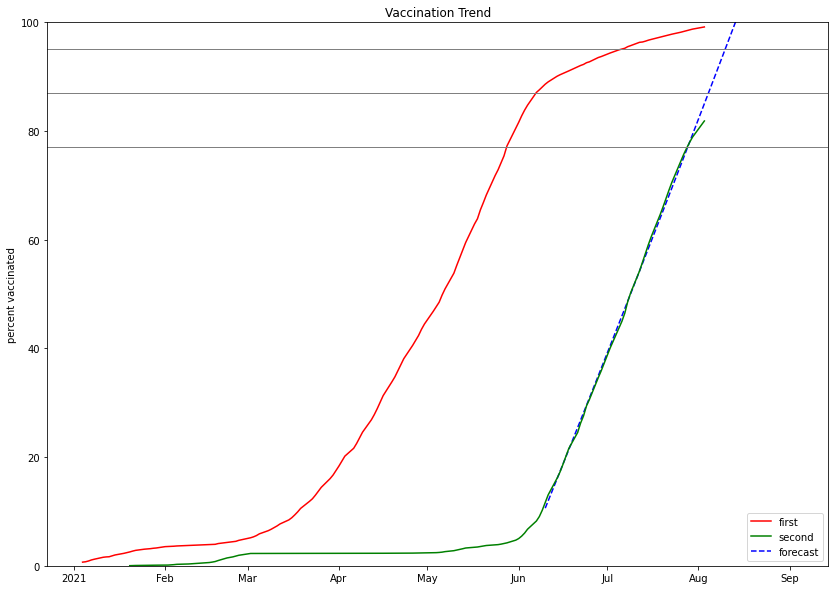

In [11]:
fig, ax = plt.subplots()

fig.set_size_inches(14, 10)

# formatting
ax.set_ylabel("percent vaccinated")
ax.set_title("Vaccination Trend")
ax.set_ylim(0, 100)

# fancy date formatting for x-axis tick labels
locator = mdates.AutoDateLocator(minticks=3, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

forecast, = ax.plot(
    np.linspace(ordinal_dates[100], ordinal_dates[-1] + FORECAST),
    np.polyval(trendline, np.linspace(ordinal_dates[100], ordinal_dates[-1] + FORECAST)),
    color="blue",
    label="forecast",
    linestyle="dashed"

) # cubic polynomial trendline

raw, = ax.plot(singleshots[0], singleshots[1], color="red", label="first")  # raw data
double, = ax.plot(doubleshots[0], doubleshots[1], color="green", label="second")  # doubleshots

age = 50
for demo_sum in demo_sums:
    line = ax.axhline(demo_sum, color="grey", linewidth=1, label=f"{age}-{age+4}")
    age -= 5
#perhaps these could be major ticks?

ax.legend([raw, double, forecast], [raw.get_label(), double.get_label(), forecast.get_label()])

plt.show()
